=== DUTCH PROTEIN DIETS: FOOD-FEED COMPETITION ===

=== SCENARIO SUMMARY ===
                 soy_land_pc  total_land_pc   water_pc  protein_pc
scenario                                                          
Current               312.26         981.24  814429.98       28.41
Red meat cap          224.76         607.61  509960.00       22.00
50/50                 220.61         501.92  439274.28       22.00
40/60                 216.27         450.27  401571.25       22.00
40/60 + chicken       255.75         551.46  488071.25       26.60

=== Full Scenario Summary Table ===
                 soy_land_pc  total_land_pc   water_pc  protein_pc  beef_kg  \
scenario                                                                      
Current               312.26         981.24  814429.98       28.41    14.90   
Red meat cap          224.76         607.61  509960.00       22.00     2.98   
50/50                 220.61         501.92  439274.28       22.00     5.73   
40/60                 

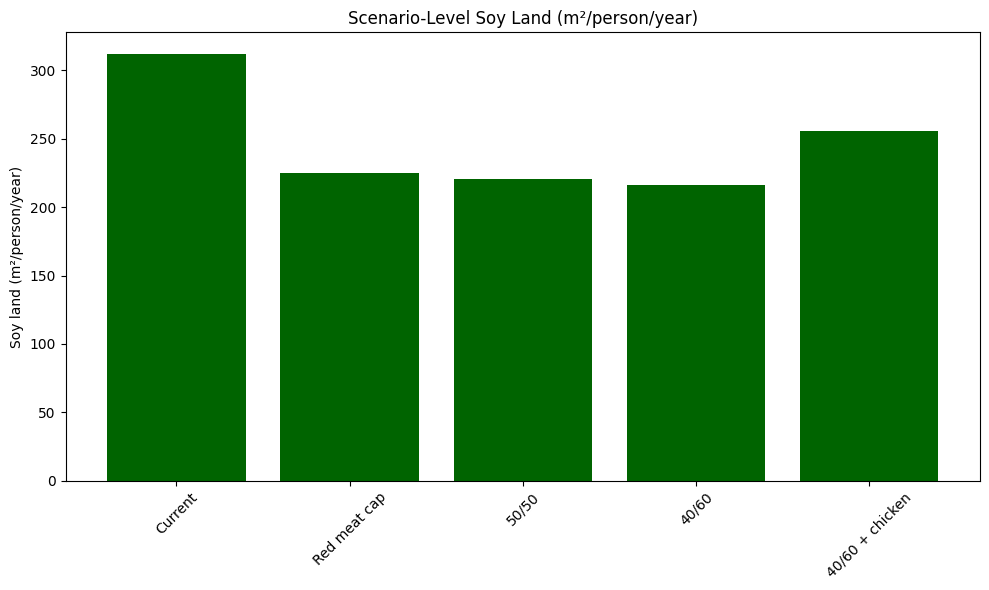

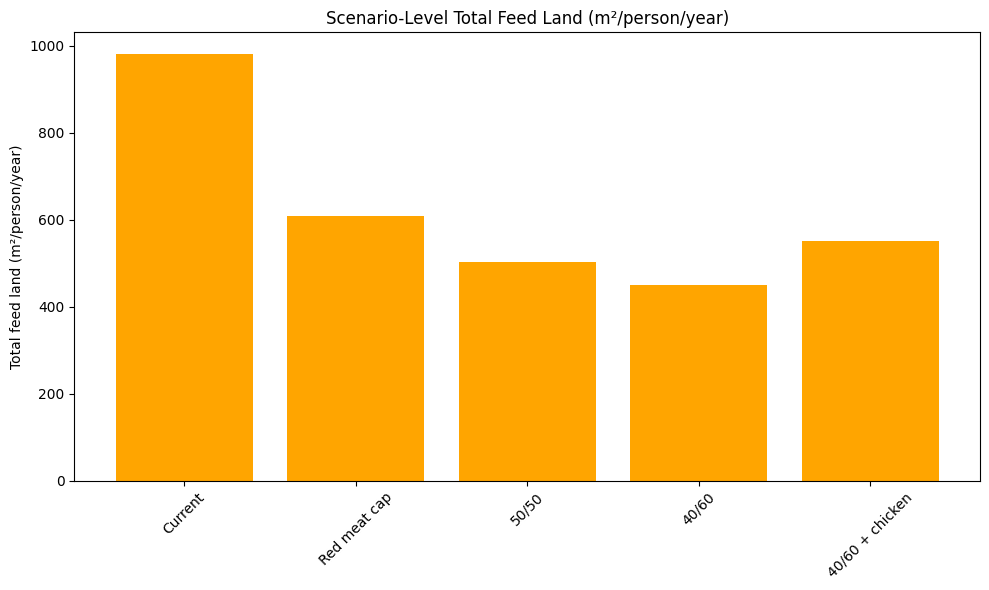

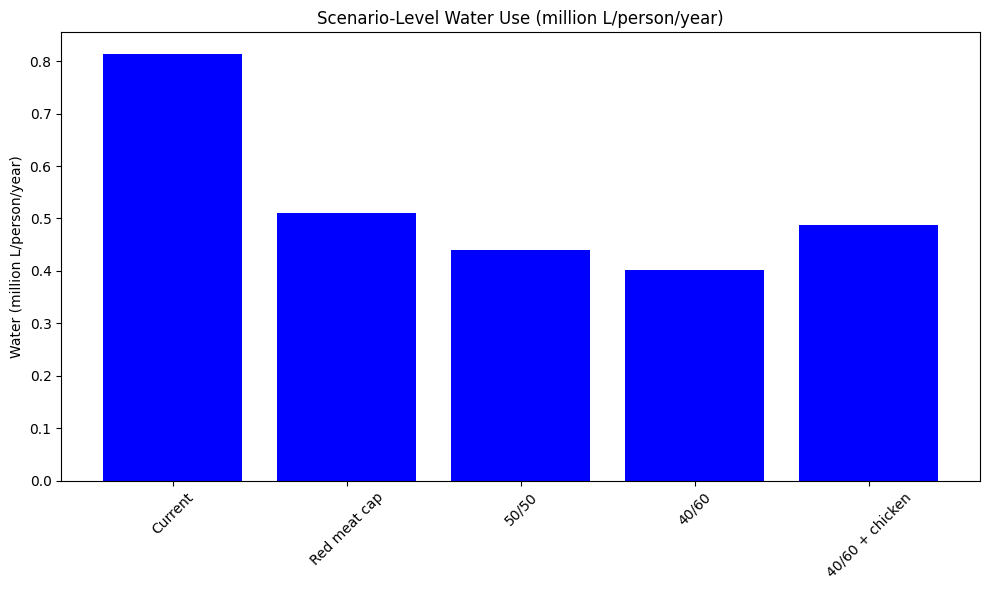

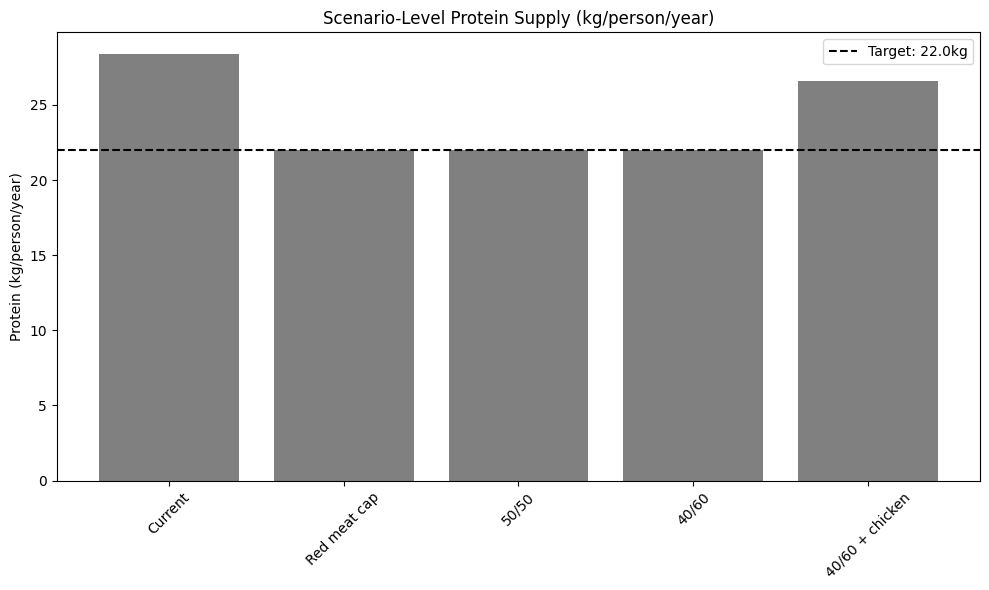

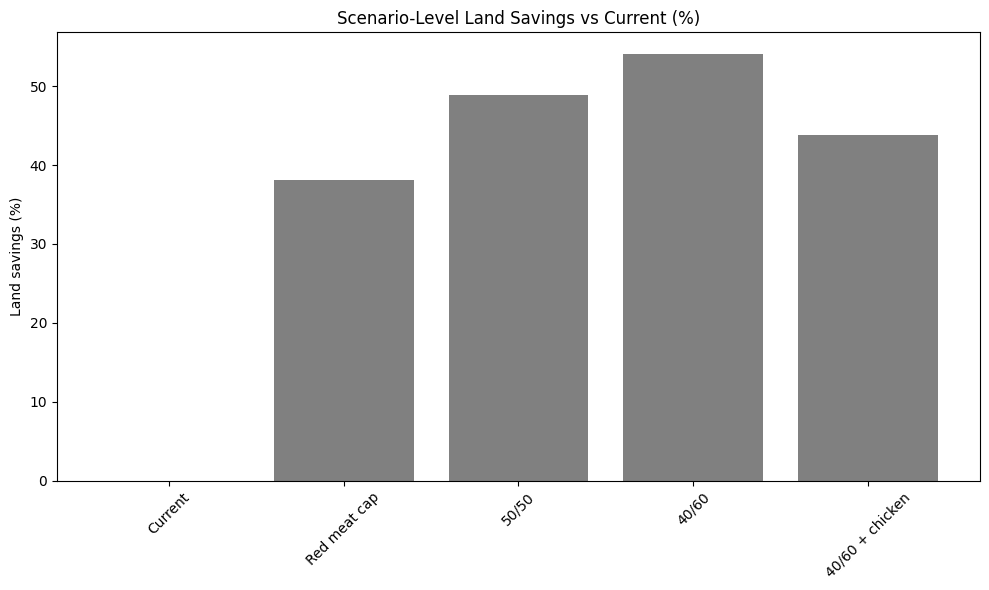

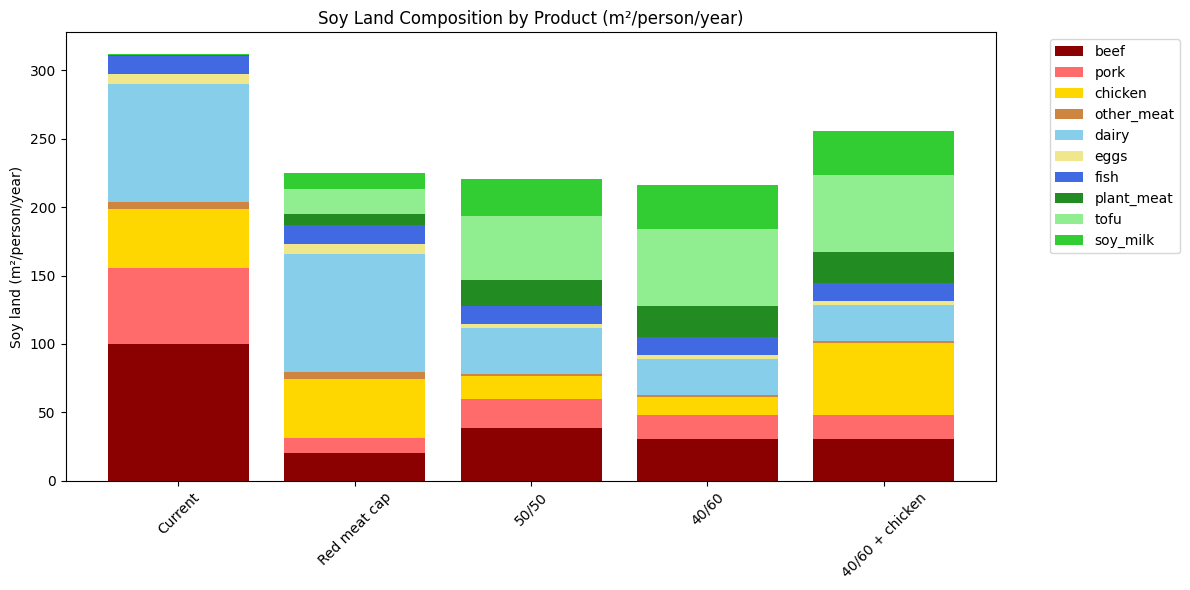

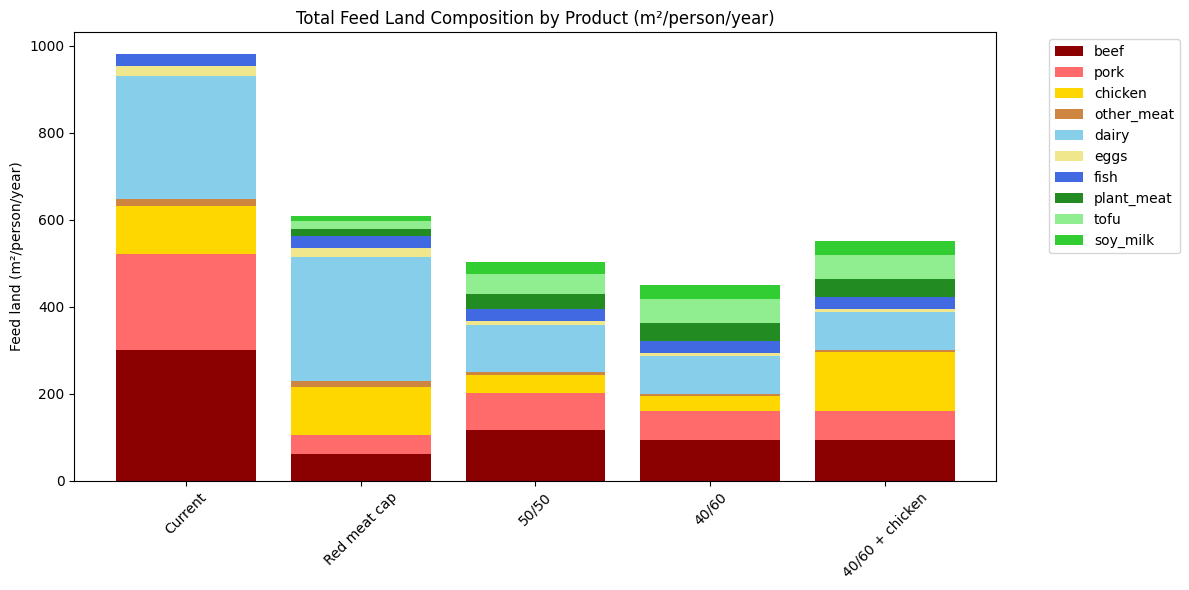

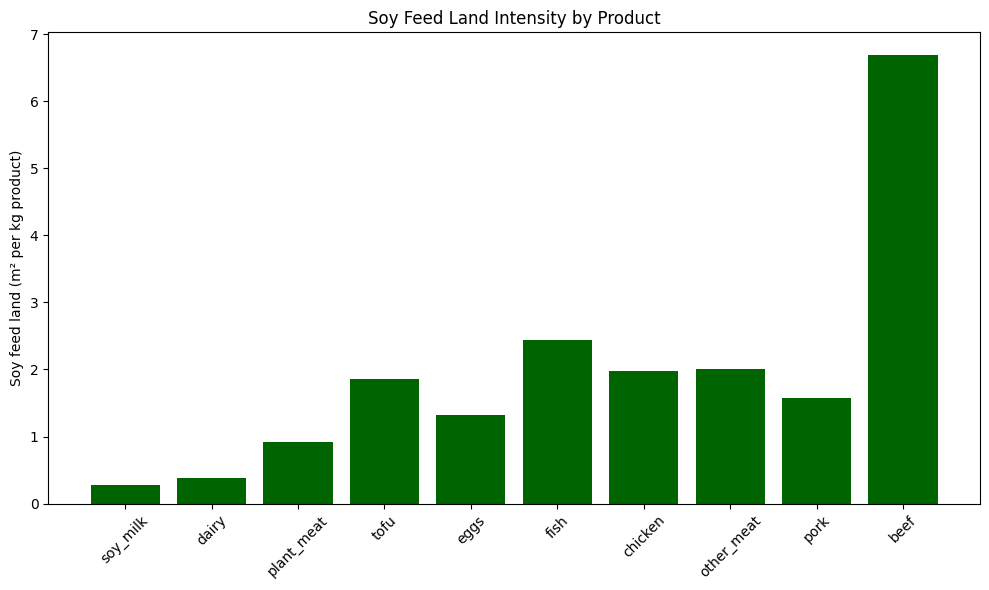

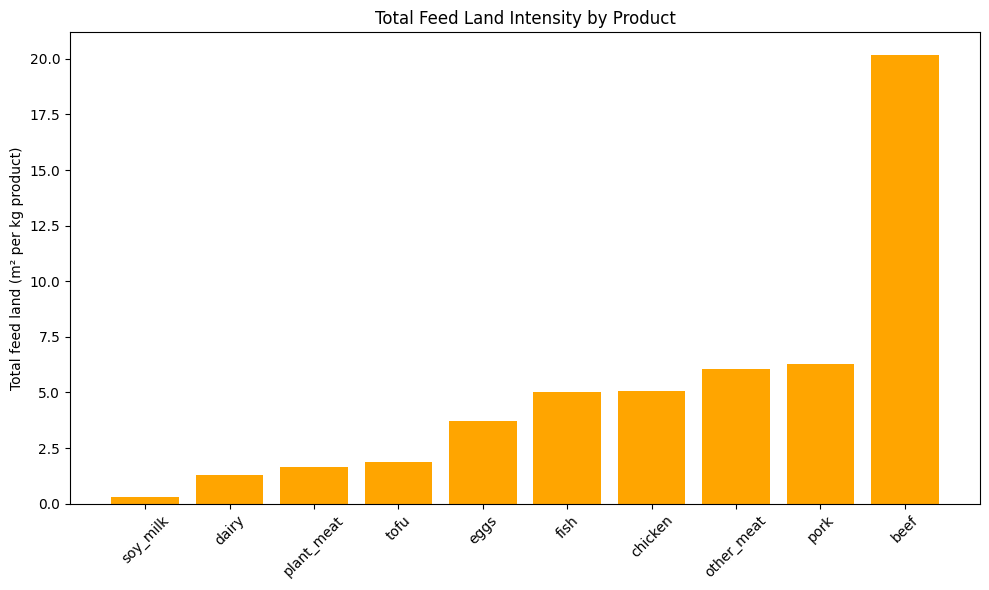

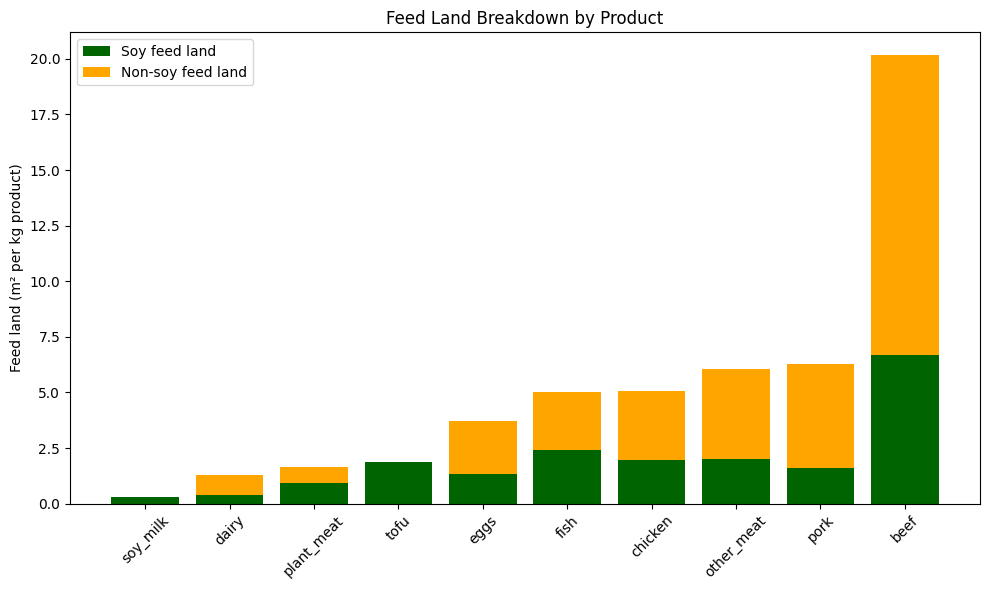

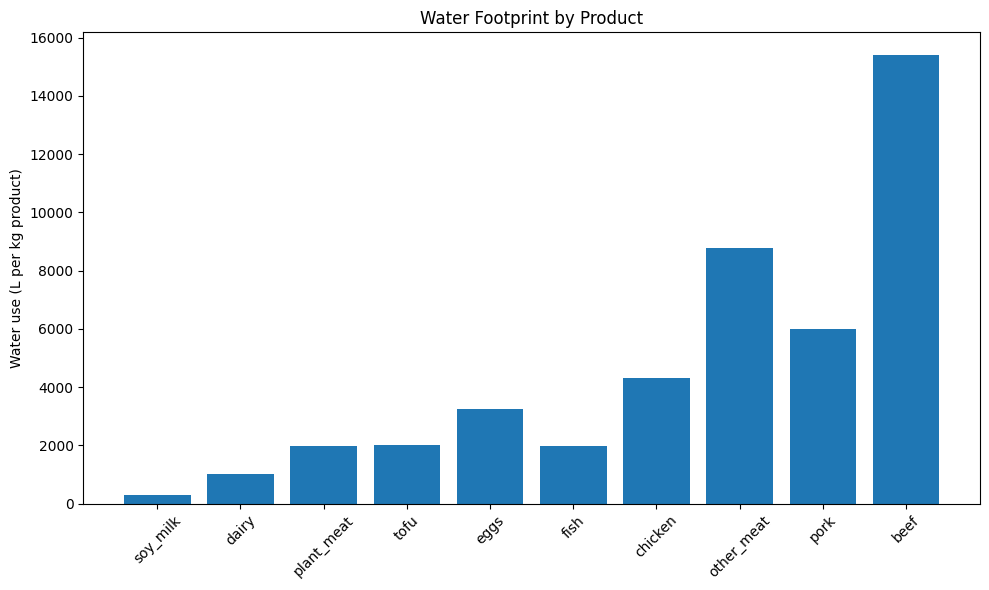

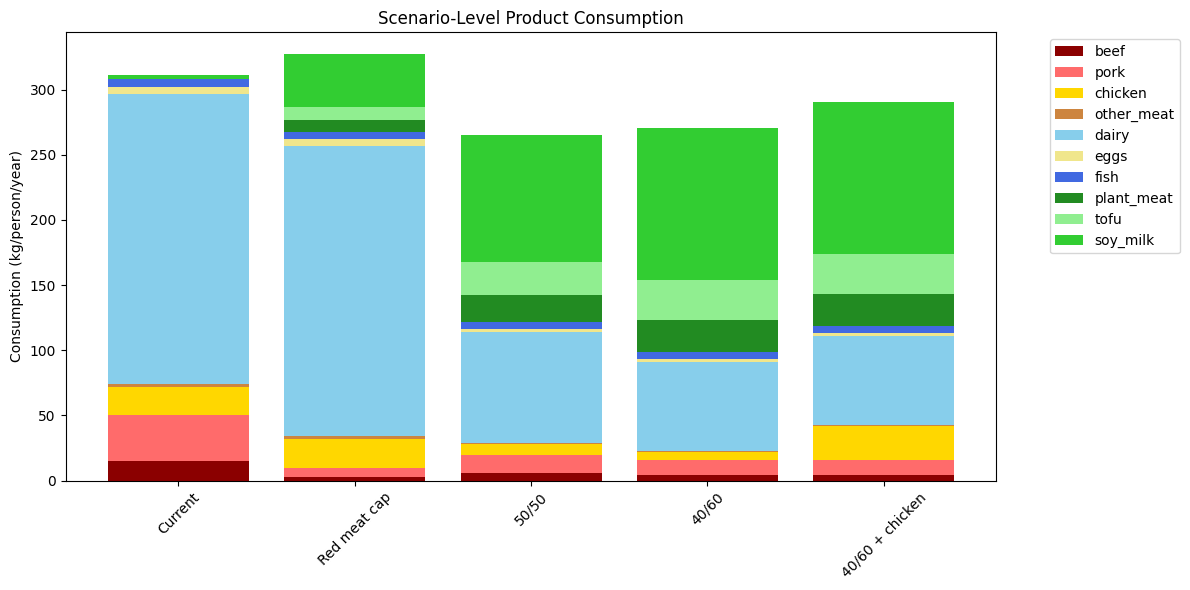


=== Scenario-Level Product Consumption (kg/person/year) ===
product           beef  chicken   dairy  eggs  fish  other_meat  plant_meat  \
scenario                                                                      
Current          14.90    22.00  222.00  5.84  5.48        2.40        0.57   
Red meat cap      2.98    22.00  222.00  5.84  5.48        2.40        8.76   
50/50             5.73     8.47   85.44  2.25  5.48        0.92       20.74   
40/60             4.59     6.77   68.35  1.80  5.48        0.74       24.89   
40/60 + chicken   4.59    26.77   68.35  1.80  5.48        0.74       24.89   

product           pork  soy_milk   tofu  
scenario                                 
Current          35.10      2.61   0.09  
Red meat cap      7.02     41.04  10.01  
50/50            13.51     97.22  25.09  
40/60            10.81    116.67  30.11  
40/60 + chicken  10.81    116.67  30.11  


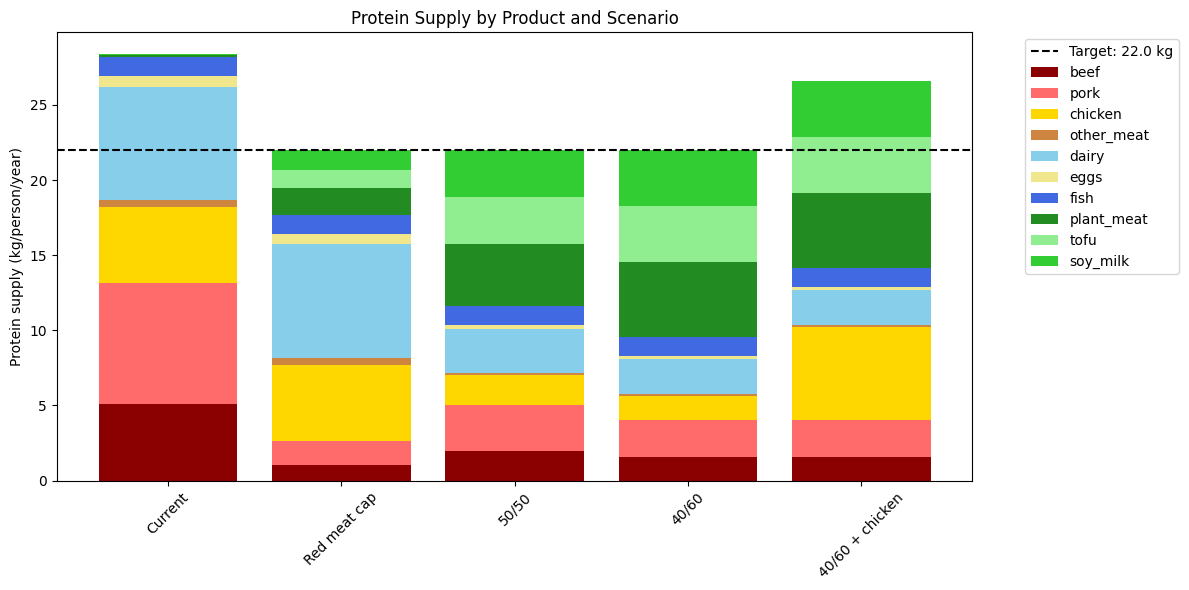


=== Protein Supply by Product and Scenario (kg/person/year) ===
product          beef  chicken  dairy  eggs  fish  other_meat  plant_meat  \
scenario                                                                    
Current          5.07     5.06   7.55  0.72  1.26        0.48        0.11   
Red meat cap     1.01     5.06   7.55  0.72  1.26        0.48        1.75   
50/50            1.95     1.95   2.90  0.28  1.26        0.18        4.15   
40/60            1.56     1.56   2.32  0.22  1.26        0.15        4.98   
40/60 + chicken  1.56     6.16   2.32  0.22  1.26        0.15        4.98   

product          pork  soy_milk  tofu  
scenario                               
Current          8.07      0.08  0.01  
Red meat cap     1.61      1.31  1.24  
50/50            3.11      3.11  3.11  
40/60            2.49      3.73  3.73  
40/60 + chicken  2.49      3.73  3.73  


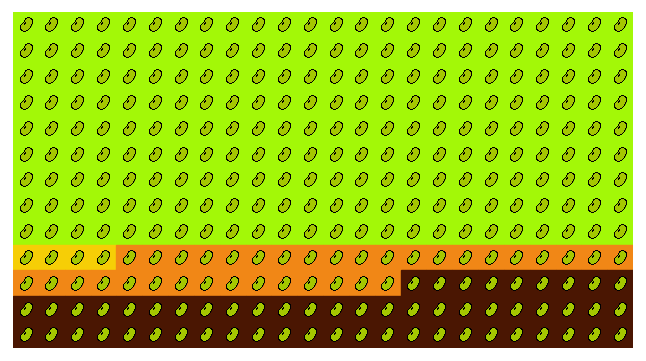

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

print("=== DUTCH PROTEIN DIETS: FOOD-FEED COMPETITION ===")

# ============================================
# 0. CONFIG
# ============================================
NL_POPULATION = 18_044_027  # 2025
PROTEIN_TARGET = 22.0  # kg protein/person/year

# Base product consumption (kg/person/year)
meat_2024_pc = {"pork": 35.1, "chicken": 22.0, "beef": 14.9, "other_meat": 2.4}
DAIRY_KG_PC = 222.0
EGGS_KG_PC = 5.840
FISH_KG_PC = 5.475  # 15 g/day (dietary guideline)
PLANT_MEAT_KG_PC = 10_200_000 / NL_POPULATION
TOFU_KG_PC = 1_630_000 / NL_POPULATION
SOY_MILK_KG_PC = 47_100_000 / NL_POPULATION

# Feed crop land (m²/kg)
CROP_LAND_M2_KG = {"maize":0.97, "wheat":1.18, "barley":1.53, "rapeseed":2.65, "soy":2.78}

# Feed shares per product
FEED_SHARES = {
    "dairy": {"maize":0.35, "soy":0.14, "wheat_barley":0.25, "rapeseed":0.08, "grass_hay":0.15, "other":0.03},
    "beef": {"maize":0.25, "soy":0.12, "wheat_barley":0.20, "rapeseed":0.06, "grass_hay":0.35, "other":0.02},
    "pork": {"maize":0.45, "soy":0.12, "wheat_barley":0.25, "rapeseed":0.08, "grass_hay":0.0, "other":0.10},
    "poultry": {"maize":0.55, "soy":0.20, "wheat_barley":0.15, "rapeseed":0.05, "grass_hay":0.0, "other":0.05},
    "eggs": {"maize":0.50, "soy":0.18, "wheat_barley":0.20, "rapeseed":0.06, "grass_hay":0.0, "other":0.06},
    "fish": {"maize":0.20, "soy":0.25, "wheat_barley":0.30, "rapeseed":0.05, "grass_hay":0.0, "other":0.20},
    "plant_meat": {"maize":0.15, "soy":0.33, "wheat_barley":0.40, "rapeseed":0.02, "grass_hay":0.0, "other":0.10},
    "plant_milk": {"maize":0.10, "soy":0.33, "wheat_barley":0.10, "rapeseed":0.02, "grass_hay":0.0, "other":0.45}
}

# Color mapping for products
prod_colors = {
    "beef": "#8B0000",
    "pork": "#FF6B6B",
    "chicken": "#FFD700",
    "other_meat": "#CD853F",
    "dairy": "#87CEEB",
    "eggs": "#F0E68C",
    "fish": "#4169E1",
    "plant_meat": "#228B22",
    "tofu": "#90EE90",
    "soy_milk": "#32CD32"
}

# ============================================
# 0.5 Scenario order (for plots, waffles)
# ============================================
scenario_order = ["Current", "Red meat cap", "50/50", "40/60", "40/60 + chicken"]

# ============================================
# 1. PRODUCTS DATAFRAME
# ============================================
products = [
    ("pork",4.74,230,"pork"),
    ("chicken",3.55,230,"poultry"),
    ("beef",20.06,340,"beef"),
    ("other_meat",6.00,200,"beef"),
    ("fish",3.50,230,"fish"),
    ("plant_meat",1.00,200,"plant_meat"),
    ("dairy",1,34,"dairy"),
    ("eggs",2.63,123,"eggs"),
    ("tofu",0.67,124,None),
    ("soy_milk",0.1,32,None)
]

df = pd.DataFrame(products, columns=["product","emcr","protein_g_kg","feed_type"])
df["soy_share"] = 0.0
df["soy_land"] = 0.0
df["non_soy_land"] = 0.0
df["total_land"] = 0.0
df["water_L_kg"] = [5988,4325,15415,8763,1974,1973,1020,3265,2000,297]

def compute_feed_land(emcr, feed_type):
    if feed_type is None:
        soy_land = emcr * CROP_LAND_M2_KG["soy"]
        return 1.0, soy_land, 0.0
    shares = FEED_SHARES[feed_type]
    soy_land = emcr * shares["soy"] * CROP_LAND_M2_KG["soy"]
    maize_kg = emcr * shares["maize"]
    wbar_kg = emcr * shares["wheat_barley"]
    rape_kg = emcr * shares["rapeseed"]
    non_soy_land = (
        maize_kg * CROP_LAND_M2_KG["maize"] +
        wbar_kg * (0.5*CROP_LAND_M2_KG["wheat"] + 0.5*CROP_LAND_M2_KG["barley"]) +
        rape_kg * CROP_LAND_M2_KG["rapeseed"]
    )
    return shares["soy"], soy_land, non_soy_land

for idx,row in df.iterrows():
    soy_share, soy_land, non_soy_land = compute_feed_land(row["emcr"], row["feed_type"])
    df.at[idx,"soy_share"]=soy_share
    df.at[idx,"soy_land"]=soy_land
    df.at[idx,"non_soy_land"]=non_soy_land
    df.at[idx,"total_land"]=soy_land+non_soy_land

# ============================================
# 2. HELPER FUNCTION
# ============================================
def add(rows, scenario, prod, kg):
    r = df.loc[df["product"]==prod].iloc[0]
    rows.append({
        "scenario": scenario,
        "product": prod,
        "kg_pc": kg,
        "protein_pc": kg * r.protein_g_kg / 1000,
        "soy_land_pc": kg * r.soy_land,
        "total_land_pc": kg * r.total_land,
        "water_pc": kg * r.water_L_kg
    })

# ============================================
# 3. SCENARIO BUILDER (modular, easier to change)
# ============================================
# ============================================
# 3. SCENARIO BUILDER (UPDATED)
# ============================================

def build_scenarios():
    scenarios = []

    # --- Current consumption ---
    current_dict = {
    **meat_2024_pc,
    "dairy": DAIRY_KG_PC,
    "eggs": EGGS_KG_PC,
    "fish": FISH_KG_PC,
    "plant_meat": PLANT_MEAT_KG_PC,
    "tofu": TOFU_KG_PC,
    "soy_milk": SOY_MILK_KG_PC  
}

    
    for prod, kg in current_dict.items():
        add(scenarios, "Current", prod, kg)

    # Compute fish protein for dietary guideline
    fish_protein = FISH_KG_PC * df.loc[df["product"]=="fish", "protein_g_kg"].iloc[0] / 1000

    # --- Helper function to scale products to a target protein ---
    def scale_to_protein(products_dict, target_protein):
        protein_per_kg = {p: df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000 for p in products_dict}
        total_protein_current = sum(products_dict[p] * protein_per_kg[p] for p in products_dict)
        factor = target_protein / total_protein_current
        return {p: products_dict[p] * factor for p in products_dict}

    # --- Scenario definitions ---
    # Define plant protein shares for substitution
    plant_protein_shares = {
    "tofu": 0.30,
    "plant_meat": 0.40,
    "soy_milk": 0.30
}


    # --- 50/50 scenario ---
    animal_products = {k: current_dict[k] for k in ["pork","chicken","beef","other_meat","dairy","eggs"]}
    plant_products = {k: current_dict[k] for k in ["tofu","plant_meat","soy_milk"]}


    # Scale to 50/50 protein target
    target_protein_5050 = PROTEIN_TARGET - fish_protein
    animal_scaled_5050 = scale_to_protein(animal_products, target_protein_5050 * 0.5)
    # Plant-based protein scaled according to defined shares
    total_plant_protein_target = target_protein_5050 * 0.5
    plant_scaled_5050 = {}
    for p in plant_products:
        plant_scaled_5050[p] = total_plant_protein_target * plant_protein_shares[p] / \
                               (df.loc[df["product"]==p, "protein_g_kg"].iloc[0]/1000)

    for prod, kg in {**animal_scaled_5050, **plant_scaled_5050}.items():
        add(scenarios, "50/50", prod, kg)
    add(scenarios, "50/50", "fish", FISH_KG_PC)

    # --- 40/60 scenario ---
    # Scale animal to 40% and plant to 60%
    animal_scaled_4060 = scale_to_protein(animal_products, target_protein_5050 * 0.4)
    total_plant_protein_target_4060 = target_protein_5050 * 0.6
    plant_scaled_4060 = {}
    for p in plant_products:
        plant_scaled_4060[p] = total_plant_protein_target_4060 * plant_protein_shares[p] / \
                               (df.loc[df["product"]==p, "protein_g_kg"].iloc[0]/1000)

    for prod, kg in {**animal_scaled_4060, **plant_scaled_4060}.items():
        add(scenarios, "40/60", prod, kg)
    add(scenarios, "40/60", "fish", FISH_KG_PC)

    # --- 40/60 + chicken scenario ---
    # Use same as 40/60 but add extra chicken (protein may exceed 22 kg)
    for prod, kg in {**animal_scaled_4060, **plant_scaled_4060}.items():
        add(scenarios, "40/60 + chicken", prod, kg)
    add(scenarios, "40/60 + chicken", "fish", FISH_KG_PC)
    # Add extra chicken directly
    add(scenarios, "40/60 + chicken", "chicken", 20)

    # --- Red meat cap ---
    current_red_meat = current_dict["beef"] + current_dict["pork"]
    cap_total = 10.0  # Red meat cap in kg/person/year
    scale_factor = cap_total / current_red_meat
    red_meat_scaled = {
        "beef": current_dict["beef"] * scale_factor,
        "pork": current_dict["pork"] * scale_factor
    }
    rest_products = {k: current_dict[k] for k in current_dict if k not in red_meat_scaled}
    # Compute total protein from red meat and rest products
    protein_from_red = sum(red_meat_scaled[p]*df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000 for p in red_meat_scaled)
    protein_rest = sum(rest_products[p]*df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000 for p in rest_products)
    protein_gap = PROTEIN_TARGET - (protein_from_red + protein_rest)
    
    # Scale plant-based products to fill protein gap if necessary
    plant_scaled_redmeat = {}
    total_plant_protein_target_red = max(0, protein_gap)
    for p in plant_products:
        plant_scaled_redmeat[p] = total_plant_protein_target_red * plant_protein_shares[p] / \
                                   (df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000)

    for prod, kg in red_meat_scaled.items():
        add(scenarios, "Red meat cap", prod, kg)
    for prod, kg in rest_products.items():
        add(scenarios, "Red meat cap", prod, kg)
    for prod, kg in plant_scaled_redmeat.items():
        add(scenarios, "Red meat cap", prod, kg)

    return pd.DataFrame(scenarios)




all_scenarios = build_scenarios()

# ============================================
# 4. SUMMARY TABLES
# ============================================
agg_pc = all_scenarios.groupby("scenario")[["soy_land_pc","total_land_pc","water_pc","protein_pc"]].sum().reindex(scenario_order)
print("\n=== SCENARIO SUMMARY ===")
print(agg_pc.round(2))

pivot = all_scenarios.pivot_table(index="scenario", columns="product", values="total_land_pc", aggfunc="sum", fill_value=0).reindex(scenario_order)
pivot_soy = all_scenarios.pivot_table(index="scenario", columns="product", values="soy_land_pc", aggfunc="sum", fill_value=0).reindex(scenario_order)
pivot_kg = all_scenarios.pivot_table(index="scenario", columns="product", values="kg_pc", aggfunc="sum", fill_value=0).reindex(scenario_order)
pivot_protein = all_scenarios.pivot_table(index="scenario", columns="product", values="protein_pc", aggfunc="sum", fill_value=0).reindex(scenario_order)

# Full summary table
summary_table = agg_pc.join(pivot_kg.add_suffix("_kg")).join(pivot_protein.add_suffix("_protein"))
print("\n=== Full Scenario Summary Table ===")
print(summary_table.round(2))

# ============================================
# 5. SCENARIO-LEVEL PLOTS
# ============================================

# Soy land
plt.figure(figsize=(10,6))
plt.bar(agg_pc.index, agg_pc["soy_land_pc"], color="darkgreen")
plt.title("Scenario-Level Soy Land (m²/person/year)")
plt.ylabel("Soy land (m²/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Total feed land
plt.figure(figsize=(10,6))
plt.bar(agg_pc.index, agg_pc["total_land_pc"], color="orange")
plt.title("Scenario-Level Total Feed Land (m²/person/year)")
plt.ylabel("Total feed land (m²/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Water
plt.figure(figsize=(10,6))
plt.bar(agg_pc.index, agg_pc["water_pc"]/1e6, color="blue")
plt.title("Scenario-Level Water Use (million L/person/year)")
plt.ylabel("Water (million L/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Protein supply
plt.figure(figsize=(10,6))
plt.bar(agg_pc.index, agg_pc["protein_pc"], color="grey")
plt.title("Scenario-Level Protein Supply (kg/person/year)")
plt.ylabel("Protein (kg/person/year)")
plt.axhline(y=PROTEIN_TARGET, color="black", linestyle="--", label=f"Target: {PROTEIN_TARGET}kg")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Land savings
plt.figure(figsize=(10,6))
current_total = agg_pc.loc["Current","total_land_pc"]
land_savings = [(1 - v/current_total)*100 for v in agg_pc["total_land_pc"]]
plt.bar(agg_pc.index, land_savings, color="grey")
plt.title("Scenario-Level Land Savings vs Current (%)")
plt.ylabel("Land savings (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Soy land composition by product
plt.figure(figsize=(12,6))
bottom = np.zeros(len(pivot_soy))
for prod in prod_colors:
    if prod in pivot_soy.columns:
        plt.bar(pivot_soy.index, pivot_soy[prod], bottom=bottom, color=prod_colors[prod], label=prod)
        bottom += pivot_soy[prod].values
plt.title("Soy Land Composition by Product (m²/person/year)")
plt.ylabel("Soy land (m²/person/year)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# Feed land composition by product
plt.figure(figsize=(12,6))
bottom = np.zeros(len(pivot))
for prod in prod_colors:
    if prod in pivot.columns:
        plt.bar(pivot.index, pivot[prod], bottom=bottom, color=prod_colors[prod], label=prod)
        bottom += pivot[prod].values
plt.title("Total Feed Land Composition by Product (m²/person/year)")
plt.ylabel("Feed land (m²/person/year)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# ============================================
# 6. PRODUCT-LEVEL FOOTPRINTS
# ============================================

df_sorted = df.sort_values("total_land")

# Soy feed land only
plt.figure(figsize=(10,6))
plt.bar(df_sorted["product"], df_sorted["soy_land"], color="darkgreen")
plt.ylabel("Soy feed land (m² per kg product)")
plt.title("Soy Feed Land Intensity by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Total feed land
plt.figure(figsize=(10,6))
plt.bar(df_sorted["product"], df_sorted["total_land"], color="orange")
plt.ylabel("Total feed land (m² per kg product)")
plt.title("Total Feed Land Intensity by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feed land breakdown (soy vs non-soy)
plt.figure(figsize=(10,6))
bottom = np.zeros(len(df_sorted))
plt.bar(df_sorted["product"], df_sorted["soy_land"], bottom=bottom, color="darkgreen", label="Soy feed land")
bottom += df_sorted["soy_land"].values
plt.bar(df_sorted["product"], df_sorted["non_soy_land"], bottom=bottom, color="orange", label="Non-soy feed land")
plt.ylabel("Feed land (m² per kg product)")
plt.title("Feed Land Breakdown by Product")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Water footprint
plt.figure(figsize=(10,6))
plt.bar(df_sorted["product"], df_sorted["water_L_kg"], color="tab:blue")
plt.ylabel("Water use (L per kg product)")
plt.title("Water Footprint by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ============================================
# 7. SCENARIO-LEVEL PRODUCT CONSUMPTION
# ============================================

fig, ax = plt.subplots(figsize=(12,6))
bottom = np.zeros(len(pivot_kg))
for prod in prod_colors:
    if prod in pivot_kg.columns:
        ax.bar(range(len(pivot_kg)), pivot_kg[prod], bottom=bottom, color=prod_colors[prod], label=prod)
        bottom += pivot_kg[prod].values
ax.set_xticks(range(len(pivot_kg)))
ax.set_xticklabels(pivot_kg.index, rotation=45)
ax.set_ylabel("Consumption (kg/person/year)")
ax.set_title("Scenario-Level Product Consumption")
ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()
print("\n=== Scenario-Level Product Consumption (kg/person/year) ===")
print(pivot_kg.round(2))

# Protein supply by product
fig, ax = plt.subplots(figsize=(12,6))
bottom = np.zeros(len(pivot_protein))
for prod in prod_colors:
    if prod in pivot_protein.columns:
        ax.bar(range(len(pivot_protein)), pivot_protein[prod], bottom=bottom, color=prod_colors[prod], label=prod)
        bottom += pivot_protein[prod].values
ax.set_xticks(range(len(pivot_protein)))
ax.set_xticklabels(pivot_protein.index, rotation=45)
ax.set_ylabel("Protein supply (kg/person/year)")
ax.set_title("Protein Supply by Product and Scenario")
ax.axhline(y=PROTEIN_TARGET, color="black", linestyle="--", label=f"Target: {PROTEIN_TARGET} kg")
ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()
print("\n=== Protein Supply by Product and Scenario (kg/person/year) ===")
print(pivot_protein.round(2))

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Soy land per scenario (rounded for visualization) #tb checked again
soy_land_pc = {
    "Current": 312,
    "Red meat cap": 224,
    "40/60 + chicken": 255,
    "50/50": 220,
    "40/60": 216
}

# Order from lowest to highest so each scenario shows the difference
scenario_order = ["40/60", "50/50", "40/60 + chicken", "Red meat cap", "Current"]

# Colors for scenarios
colors = {
    "40/60": "#a3f807",
    "50/50": "#f6ce06",
    "40/60 + chicken": "#f18716",
    "Red meat cap": "#fc4503",
    "Current": "#4A1602"
}

# Load soybean icon (transparent PNG)
icon_path = "soybean.png"
soy_icon = Image.open(icon_path)

# Waffle grid config
n_cols = 24
n_rows = 13
max_cells = n_cols * n_rows
icon_zoom = 0.05  # adjust depending on PNG size

# Compute scenario differences (to know how many squares each scenario adds)
prev = 0
scenario_diff = {}
for sc in scenario_order:
    scenario_diff[sc] = soy_land_pc[sc] - prev
    prev = soy_land_pc[sc]

# Create figure
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')

# Remove axes, ticks, and spines
ax.set_xlim(0, n_cols)
ax.set_ylim(0, n_rows)
ax.axis('off')  # hides all ticks, labels, and spines

# Draw the background squares for each scenario
current_idx = 0
for sc in scenario_order:
    for i in range(scenario_diff[sc]):
        x = current_idx % n_cols
        y = n_rows - 1 - current_idx // n_cols
        ax.add_patch(plt.Rectangle((x, y), 1, 1, color=colors[sc], zorder=0))
        current_idx += 1

# Overlay soybean PNGs on every square
for i in range(prev):  # prev = total squares
    x = i % n_cols
    y = n_rows - 1 - i // n_cols
    imagebox = OffsetImage(soy_icon, zoom=icon_zoom)
    ab = AnnotationBbox(imagebox, (x+0.5, y+0.5), frameon=False, zorder=1)
    ax.add_artist(ab)



plt.show()
